In [1]:
%matplotlib inline
import numpy as np
import scipy.integrate as ode
import matplotlib.pyplot as plt
import matplotlib as mpl
from ipywidgets import interact, interactive, fixed, interact_manual,widgets
import ipywidgets
from IPython.display import display
from mpl_toolkits.mplot3d import Axes3D
import networkx as nx
from IPython.display import HTML
plt.rc("figure",figsize=(16,10))

# Tools for computing the trajectories

In [2]:
###basic function for the system###
def fitness(A,mu=1):
    """Computation of the fitness of the reducted model.
    A is the matrix of interaction and mu is the ratio I/II
    """
    n=len(A)
    return np.array(mu*(A.T-A)+A.T-np.matrix(np.ones((n,1)))*np.matrix(np.diagonal(A)))
def theta(R0,k,beta=1):
    T=1-1/R0
    I=(R0-1)/(R0+R0*k*(R0-1))
    D=T-I
    return beta*I*D*T/(2*T**2-I*D) 
def thetamu(R0,k,beta=1):
    return theta(R0,k,beta=beta)/(R0-1)*k
def slowdyn(T,z,Lambda=None,D=1):
    n=len(z)
    #z=np.array([max(zi,10**-32) for zi in z])
    z=z/np.sum(z)
    if type(z) is list:
        z=np.array(z)
    if Lambda is None : Lambda=np.array([[]])
    if type(Lambda) is list : Lambda=np.array(Lambda)
    if np.shape(Lambda)!=(len(z),len(z)):
        print('Attention mauvais lambda. Remplacement par une valeur par défaut')
        Lambda=np.ones((len(z),len(z)))
        Lambda=Lambda-np.diag(np.diag(Lambda))
    Q=np.dot(z.T,np.dot(Lambda,z))
    L=np.dot(Lambda,z)
    D*z*(L-Q)
    return D*z*(L-Q)

In [4]:
###Solver###
def traject(T,X0,fit,D=1,isdense=True):
    """kwargs=[A,mu] or kwargs=[Lambda]"""

    if type(X0) is list: X0=np.array(X0)
    if (X0<0).any() : 
        #print('negativ entry')
        X0=np.abs(X0)
    if (X0==0).all() : 
        print('no positiv entry')
        X0=np.abs(X0+0.1)  
    X0=X0/np.sum(X0)
    def f_eval(t,X):
        Z=slowdyn(t,X,Lambda=fit,D=D)[:-1]
        return np.concatenate((Z,-np.array([sum(Z)])))
    resultat = ode.solve_ivp(fun=f_eval,
                             t_span=(0, T), 
                             y0=X0,
                             dense_output=isdense
                             #t_eval=np.arange(0,T,0.1),
                            )
    return resultat

In [279]:
def simu(T=100,mu=None,A=None,fit=None,n=3,z0=None,T_threshold=None,V_threshold=10**-4,**kwargs):
    """Compute the dynamics for a n strain system.
    Input are :
    -T the final time 
    -mu the ratio I/D=1/(k(R0-1))
    -A the array of rescalled interactions.  A is automatiquely renormalised such that the euclidan norm is ||A||=1
    -fit the matrix of fitness (usefull if neither mu nor A is given).
    -n the number of species (usefull is neither mu nor A nor fit is given)
    If mu and A are given, the fitness is computed by the function fitness.
    If mu is given and not A, then A is generated randomly using a uniform distribution between -1 and 1
    If A is given and not mu then mu is generated randomly using a uniform distribution between 0 and 10
    If none of mu, A or fit are  given, then mu=1 and A  is generated by using a uniform distribution between -1 and 1.
    
    Additional arguments are 
    -z0 : the initial data
    -V_threshold : If z_i < threshold, then the strain i is considered to be not here
    -T_threshold: a percentage of T from which we compute the threshold. Default is 100%
    The output are mu, A, fit, the resultat of the dynamics and the number of coexistent species
    """
    if mu is not None and A is  None :
        A=2*np.random.random((n,n))-1
    if  A is not None :
        if A is list:   A=np.array(A) ## Transform A in Array
        A=A/sum(sum(A**2)) ## renormalisation of A
        if mu is None : mu=10*np.random.random(1) ##generation of mu if needed
        n=len(A)
        fit=fitness(A=A,mu=mu)
    if mu is None and A is None and fit is None :
        mu=1
        A=2*np.random.random((n,n))-1
        A=A/sum(sum(A**2))
        fit=fitness(A=A,mu=mu)
    n=len(fit)
    if z0 is not None and len(z0)!=n : 
        print('Mistake in z0, the size len(z0)={}'.format(len(z0)),
                                                          r'$\ned$',
                                                          'n={}'.format(n),
                                                          'a random z0 is taken.') 
        z0=np.random.random(n)
    if z0 is None : z0=np.random.random(n)  ##Generation of the initial data
    ##Computation of the dynamics
    D=kwargs.pop('D',1)
    resultat=traject(T=T,X0=z0,fit=fit,D=D)
    if T_threshold is None : nc=len(resultat.y[:,-1][resultat.y[:,-1]>V_threshold])
    
    else :  
            Tstart=T*T_threshold
            ind_threshold=np.int(np.min(np.arange(0,len(resultat.t),1)[resultat.t>Tstart].tolist()+[T]))
            mean=np.mean(resultat.y[:,ind_threshold:],axis=1)
            nc=len(mean[mean>V_threshold])
    return mu, A,fit,resultat,nc


def essai(resultat=None,details=1000,ax=None,isplot=True,**kwargs):
    """Plot the dynamics from simu"""
    if resultat is None :
        mu, A,fit,resultat,nc=simu(**kwargs)
        kwargs['mu']=mu
        kwargs['A']=A
        kwargs['fit']=fit
        kwargs['nc']=nc
    D=kwargs.pop('D',1)
    z0=kwargs.pop('z0',None)        
    mu=kwargs.pop('mu',None)
    n=kwargs.pop('n',3)
    A=kwargs.pop('A',None)
    fit=kwargs.pop('fit',None)
    nc=kwargs.pop('nc',None)
    T=kwargs.pop('T',resultat.t[-1])
    V_threshold=kwargs.pop('V_threshold',10**-4)
    T_threshold=kwargs.pop('T_threshold',1)
    n=len(resultat.y)
    if ax is None : 
        fig,ax=plt.subplots() 
        
    y=resultat.sol(np.linspace(0,T,details))
    for i in range(np.shape(resultat.y)[0]):
        ax.plot(np.linspace(0,T,details),y[i],**kwargs,visible=isplot)
    titre='N={} strains and '.format(n) 
    coexist=(nc>1)*'{} strains coexist'.format(nc)+(nc==1)*'1 strain survives '
    mean= '\n(mean> {:0.0e} on the last {:0.0f}% of time) '.format(V_threshold, (1-T_threshold)*100)
    ax.set_title(titre+coexist+mean) 
    ax.set_xlabel('Slow time scale '+r'$\tau$',fontsize=30)
    ax.set_ylabel('Strain frequency $z_i$', fontsize=30)
    ax.yaxis.set_ticks_position('left')
    
    RETURN={}
    RETURN['mu']=mu
    RETURN['A']= A
    RETURN['fit']=fit
    RETURN['res']=resultat
    RETURN['nc']=nc
    return RETURN

# Tools  for the graph

In [5]:
def network(LL):
    """define the graph for a given fitness LL"""
    if LL is list :
        LL=np.array(LL)
    LL=LL-np.diag(np.diag(LL)) # be sure that the self fitness is zero
    G=nx.DiGraph()
    n=len(LL)
    nodes=['{}'.format(i+1) for i in range(n)]
    G.add_nodes_from(nodes)
    pair=[(i,j) for j in range(n) for i in range(n) 
           if LL[i,j] !=0 or LL[j,i] !=0  ]
    edges=[('{}'.format(x[0]+1),'{}'.format(x[1]+1)) for x in pair]
    G.add_edges_from(edges)
    for (i,j),(a,b) in zip(pair,edges):
        classe='degenerate'
        if LL[i,j]<0 and LL[j,i]<0: G[a][b]['type']='bist'
        elif LL[i,j]>0 and LL[j,i]>0: G[a][b]['type']='coex'
        elif LL[i,j]<0 and not LL[j,i]<0: G[a][b]['type']='excl_'+a
        elif not LL[i,j]<0 and LL[j,i]<0: G[a][b]['type']='excl_'+b
        #print(classe)
    return G

def net_draw(G,**kwargs):
    """plot the graph G
    kwargs as the following entry :
    - nodes : z, the size of the nodes. Default is 100
    -ax= plot on the curent ax. default is None"""
    zz=np.array(kwargs.pop('nodes',[1]*G.number_of_nodes()))
    zcolor=kwargs.pop('zcolor','grey')
    alpha=kwargs.pop('Galpha',1)
    ax=kwargs.pop('ax',None)
    nalpha=kwargs.pop('nalpha',1)
    shownumber=kwargs.pop('shownumber',False)
    if ax is None : fig,ax=plt.subplots()
    pos=nx.drawing.circular_layout(G)
    nx.draw(G,pos=pos,
            node_size=1000*zz+0.01,node_color=zcolor,alpha=nalpha,
           edgelist=[], ax=ax)
    edgecoex,edgebist,edgeexclui,edgeexcluj=[],[],[],[]
    for i,j in G.edges :
        
        if G[i][j]['type']=='coex':edgecoex.append((i,j))
        elif G[i][j]['type']=='bist':edgebist.append((i,j))
        elif G[i][j]['type']=='excl_'+i:edgeexclui.append((i,j))
        elif G[i][j]['type']=='excl_'+j:edgeexcluj.append((j,i))
    pos=nx.drawing.circular_layout(G)
    if shownumber :
        pos_labx=pos.copy()
        pos_lab=pos.copy()
        for key in pos:
            pos_labx[key]=1.*pos_labx[key]
            pos_lab[key]=key
        nx.draw_networkx_labels(G,pos=pos_labx,ax=ax,labels=pos_lab,font_size=20)
    nx.draw_networkx_edges(G,pos=pos,
                           edgelist=edgecoex,
                           edge_color='red',
                           width=4.0,
                           arrowsize=20,
                           arrows=False,
                           node_size=1000,
                           alpha=alpha,
                          ax=ax)
    nx.draw_networkx_edges(G,pos=pos,
                           edgelist=edgebist,
                           width=2.0,
                           edge_color='blue',
                           arrowsize=20,
                           arrows=False,
                           node_size=1000,
                           alpha=alpha,
                          ax=ax)
    nx.draw_networkx_edges(G,pos=pos,
                           width=2.0,
                           edgelist=edgeexclui+edgeexcluj,
                           edge_color='grey',
                           style='dotted',
                           arrowsize=20,
                           node_size=1000,
                           arrowstyle='-|>',
                           alpha=alpha,
                          ax=ax)

In [6]:
def simu(T=100,mu=None,A=None,fit=None,n=3,z0=None,T_threshold=None,V_threshold=10**-4,**kwargs):
    """Compute the dynamics for a n strain system.
    Input are :
    -T the final time 
    -mu the ratio I/D=1/(k(R0-1))
    -A the array of rescalled interactions.  A is automatiquely renormalised such that the euclidan norm is ||A||=1
    -fit the matrix of fitness (usefull if neither mu nor A is given).
    -n the number of species (usefull is neither mu nor A nor fit is given)
    If mu and A are given, the fitness is computed by the function fitness.
    If mu is given and not A, then A is generated randomly using a uniform distribution between -1 and 1
    If A is given and not mu then mu is generated randomly using a uniform distribution between 0 and 10
    If none of mu, A or fit are  given, then mu=1 and A  is generated by using a uniform distribution between -1 and 1.
    
    Additional arguments are 
    -z0 : the initial data
    -V_threshold : If z_i < threshold, then the strain i is considered to be not here
    -T_threshold: a percentage of T from which we compute the threshold. Default is 100%
    The output are mu, A, fit, the resultat of the dynamics and the number of coexistent species
    """
    fit_type=kwargs.pop('fit_type','A')

    if fit is None : 
        if fit_type=='rand':
            fit=(b-a)*np.random.random((n,n))+a
            fit=fit-np.diag(np.diag(fit))
        elif fit_type=='line':
            Lfit=(b-a)*np.random.random((n,1))+a
            fit=np.repeat(Lfit,n,axis=1)
            fit=fit-np.diag(np.diag(fit))
        elif fit_type=='col':
            Lfit=(b-a)*np.random.random((n,1))+a
            fit=np.repeat(Lfit,n,axis=1).T
            fit=fit-np.diag(np.diag(fit))
        elif fit_type=='sym':
            fit=(b-a)*np.random.random((n,n))+a
            fit=fit+fit.T
            fit=fit-np.diag(np.diag(fit))
        elif fit_type=='anti':
            fit=(b-a)*np.random.random((n,n))+a
            fit=fit-fit.T
        elif fit_type=='antir':
            fit=(b-a)*np.random.random((n,n))+a
            fit=fit-fit.T
            fit=fit+(b-a)/10*np.random.random((n,n))
        else :
            if mu is not None and A is  None :
                A=2*np.random.random((n,n))-1
            if  A is not None :
                if A is list:   A=np.array(A) ## Transform A in Array
                A=A/sum(sum(A**2)) ## renormalisation of A
                if mu is None : mu=10*np.random.random(1) ##generation of mu if needed
                n=len(A)
                fit=fitness(A=A,mu=mu)
            if mu is None and A is None and fit is None :
                mu=1
                A=2*np.random.random((n,n))-1
                A=A/sum(sum(A**2))
                fit=fitness(A=A,mu=mu)
    n=len(fit)

    if z0 is not None and len(z0)!=n : 
        print('Mistake in z0, the size len(z0)={}'.format(len(z0)),
                                                          r'$\ned$',
                                                          'n={}'.format(n),
                                                          'a random z0 is taken.') 
        z0=np.random.random(n)
    if z0 is None : z0=np.random.random(n)  ##Generation of the initial data
    ##Computation of the dynamics
    D=kwargs.pop('D',1)
    isdense=kwargs.pop('isdense',True)
    resultat=traject(T=T,X0=z0,fit=fit,D=D,isdense=isdense)
    if T_threshold is None : nc=len(resultat.y[:,-1][resultat.y[:,-1]>V_threshold])
    
    else :  
            Tstart=T*T_threshold
            ind_threshold=np.int(np.min(np.arange(0,len(resultat.t),1)[resultat.t>Tstart].tolist()+[T]))
            mean=np.mean(resultat.y[:,ind_threshold:],axis=1)
            nc=len(mean[mean>V_threshold])
    return mu, A,fit,resultat,nc
def dyna_q(fit,resultat,TT):
    YY=resultat.sol(TT)
    q=[]
    for k in range(len(YY.T)):
        z=np.array([list(YY[:,k])])
        q.append(sum(sum(fit*(z.T@z))))
        
    return q

def matshow(A,ax=None,cmap='seismic',barun=False,a=-1,b=1):
    N=len(A)
    if ax is None :
        fig,ax=plt.subplots()
    if barun:    
        cmin,cmax=a,b
    else : cmin,cmax=np.min(A),np.max(A)
    maps=ax.imshow(A,cmap=cmap,vmin=a,vmax=b)
    cbar=plt.colorbar(maps,ax=ax,shrink=1)
    #ax.set_xlabel(r'Resident $j$',fontsize=30)
    
    ax.set_xticks(range(0,N))
    ax.set_xticklabels(range(1,N+1),fontsize=20)
    ax.set_yticks(range(0,N))
    ax.set_yticklabels(range(1,N+1),fontsize=20)
    ax.grid(False)
    return ax,maps,cbar    
def graph_zq(TT,sol,fit,AX=None):
    Z=sol(TT)
    Q=[np.dot(np.dot(fit,z),z) for z in Z.T]
    if AX is None :fig,(ax1,ax2)=plt.subplots(ncols=2)
    else : (ax1,ax2)=AX
    ax2.plot([TT[0],TT[-1]],[0,0],'-k')
    ax2.set_xlim((TT[0],TT[-1]))
    ax1.set_xlim((TT[0],TT[-1]))
    ax1.set_ylim((0,1))
    ax1.stackplot(TT,Z,lw=10)
    ax2.plot(TT,Q,lw=10)
    ax1.set_title('Frequencies\' dynamics\n without invasion',fontsize=25)
    ax2.set_title('Dynamics of Q\n without invasion',fontsize=25)
    ax1.set_xlabel(r'Time $\tau$',fontsize=35)
    ax1.set_ylabel(r'Species frequency $z_i$',fontsize=35,rotation=90)
    ax2.set_xlabel(r'Time $\tau$',fontsize=35)
    ax2.set_ylabel(r'Mean invasion fitness $Q(\tau)$',fontsize=35,rotation=90)
    #ax2.set_ylabel(r'$Q(\tau)$',fontsize=15,rotation=0)
    ax1.set_yticklabels([f'{round(u,1)}' for u in ax1.get_yticks()],fontsize=14)
    uticks2=ax2.get_yticks()
    ax2.set_yticklabels([f'{u:0.2f}' for u in ax2.get_yticks()[::]],fontsize=14)
    return Q

In [10]:
fit0=None
z0=None

C:\Users\stenm\AppData\Local\Temp/ipykernel_15932/3717727695.py:124: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels([f'{round(u,1)}' for u in ax1.get_yticks()],fontsize=14)
C:\Users\stenm\AppData\Local\Temp/ipykernel_15932/3717727695.py:126: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels([f'{u:0.2f}' for u in ax2.get_yticks()[::]],fontsize=14)


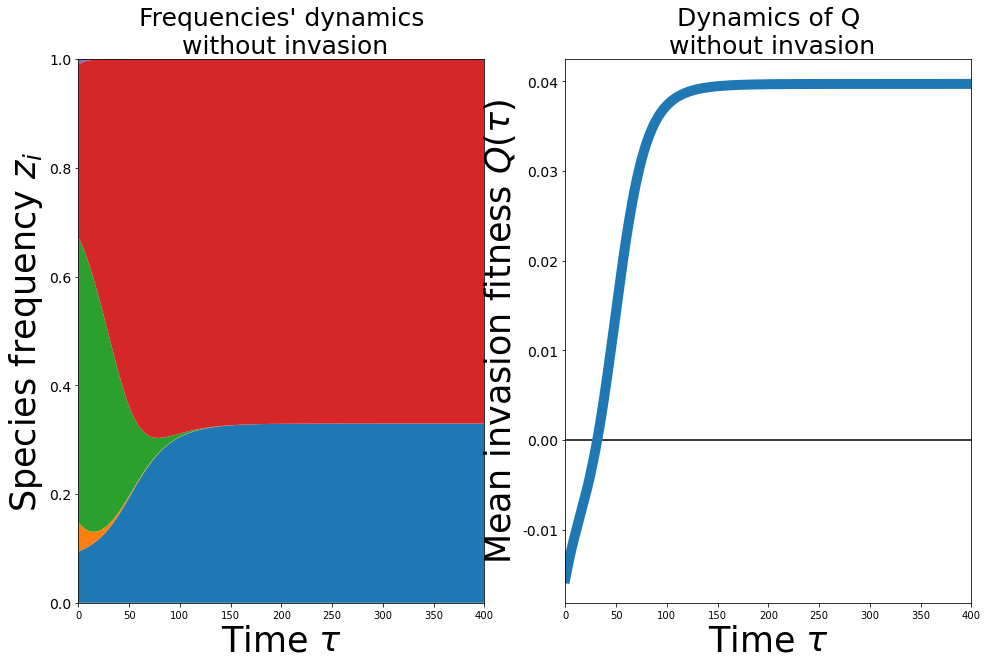

In [12]:
Tmax=400
mu, A,fit1,resultat,nc=simu(n=5,T=Tmax,fit=fit0,z0=z0,mu=0.2)
TT=np.linspace(0,Tmax,1000)
Q=graph_zq(TT,resultat.sol,fit1)

# Tools for adding an invader

In [13]:
def invasion(k,TT,sol,mu,fit,invstrength=None,invresist=None,Tafter=10,gap=0.9,finv=0.001):
    n=len(fit)
    if invstrength is None: invstrength=2*np.random.random((1,n))-1
    if invresist is None: invresist=2*np.random.random((n+1,1))-1
    invresist[-1,-1]=0
    zinit=np.array(list(sol(TT[k]))+[finv])
    fitnew=np.concatenate((np.concatenate((fit,invstrength),axis=0),invresist),axis=1)
    mu, A,fit,resultat_inv,nc=simu(T=Tafter,z0=zinit,fit=fitnew,mu=mu,T_threshold=gap)
    
    TT_inv=np.linspace(0,Tafter,1000)
    succes=False
    long_succes=False
    if np.max(resultat_inv.sol(TT_inv)[-1])>finv : succes=True
    if np.max(resultat_inv.sol(TT_inv)[-1][int(gap*len(TT)):])>finv : long_succes=True
    dico={}
    diconew={}
    dico['k']=k
    dico['resultat_inv']=resultat_inv
    dico['TT_inv']=TT_inv
    dico['nc']=nc
    dico['fit']=fit
    dico['succes']=succes
    dico['long_succes']=long_succes
    diconew['invstrength']=invstrength
    diconew['invresist']=invresist
    
    return dico,diconew

def invasion_graph(TT,sol,k,resultat_inv,TT_inv,nc,fit,succes,AX=None,**kwargs):
    TTo=TT[:k]
    t_inv=TT[k]
    Zo=sol(TTo).tolist()+[len(sol(TTo)[0])*[0]]
    TTn=[t_inv+t for t in TT_inv]
    Z_inv=resultat_inv.sol(TT_inv)
    TT_bilan=np.array(TTo).tolist()+np.array(TTn).tolist()
    Z_bilan=np.array([np.array(x).tolist()+np.array(y).tolist() for x,y in zip(Zo,Z_inv)])
    Q=[np.dot(np.dot(fit,z),z) for z in Z_bilan.T]
    ########################################""
    title=f'{nc} strains coexist.' 
    if succes : title=title+'Succes of invasion'
    else : title+='Invasion failled'
    #####################################""
    if AX is None :fig,(ax1,ax2)=plt.subplots(ncols=2)
    else : (ax1,ax2)=AX
    ax2.plot([TT_bilan[0],TT_bilan[-1]],[0,0],'-k')
    ax1.set_xlim((TT_bilan[0],TT_bilan[-1]))
    ax2.set_xlim((TT_bilan[0],TT_bilan[-1]))
    ax1.set_ylim((0,1))
    ylim2=(-1.1*max(np.abs(Q)),1.1*max(np.abs(Q)))
    ax2.set_ylim(ylim2)
    ax1.stackplot(TT_bilan,Z_bilan)
    ax2.plot(TT_bilan,Q,lw=10)
    ax1.set_title('Frequencies\' dynamics\n with invasion',fontsize=25)
    ax2.set_title('Dynamics of Q\n with invasion',fontsize=25)
    ax1.set_xlabel(r'Time $\tau$',fontsize=35)
    ax2.set_xlabel(r'Time $\tau$',fontsize=35)
    ax1.set_ylabel(r'Species frequency $z_i$',fontsize=35,rotation=90)
    ax2.set_ylabel(r'Mean invasion fitness $Q(\tau)$',fontsize=35,rotation=90)
    #ax2.set_ylabel(r'Mean fitness $\bar{\lambda}$',fontsize=15)
    ax1.set_yticklabels([f'{round(u,1)}' for u in ax1.get_yticks()],fontsize=14)
    uticks2=ax2.get_yticks()
    ax2.set_yticklabels([f'{u:0.2f}' for u in ax2.get_yticks()[::]],fontsize=14)
    ax2.plot([t_inv,t_inv],[-1,1],'--k',lw=4)
    ax1.plot([t_inv,t_inv],[-1,1],'--k',lw=4)
    ax2.text(1.1*t_inv,0.1*(ax2.get_ylim()[1]-ax2.get_ylim()[0])+ax2.get_ylim()[0],'Invasion \n time',fontsize=25)
    ax1.text(1.1*t_inv,0.1,'Invasion \n time',fontsize=25)
    return TT_bilan,Z_bilan
    
    

### exemple of use

C:\Users\stenm\AppData\Local\Temp/ipykernel_15932/3717727695.py:124: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels([f'{round(u,1)}' for u in ax1.get_yticks()],fontsize=14)
C:\Users\stenm\AppData\Local\Temp/ipykernel_15932/3717727695.py:126: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels([f'{u:0.2f}' for u in ax2.get_yticks()[::]],fontsize=14)


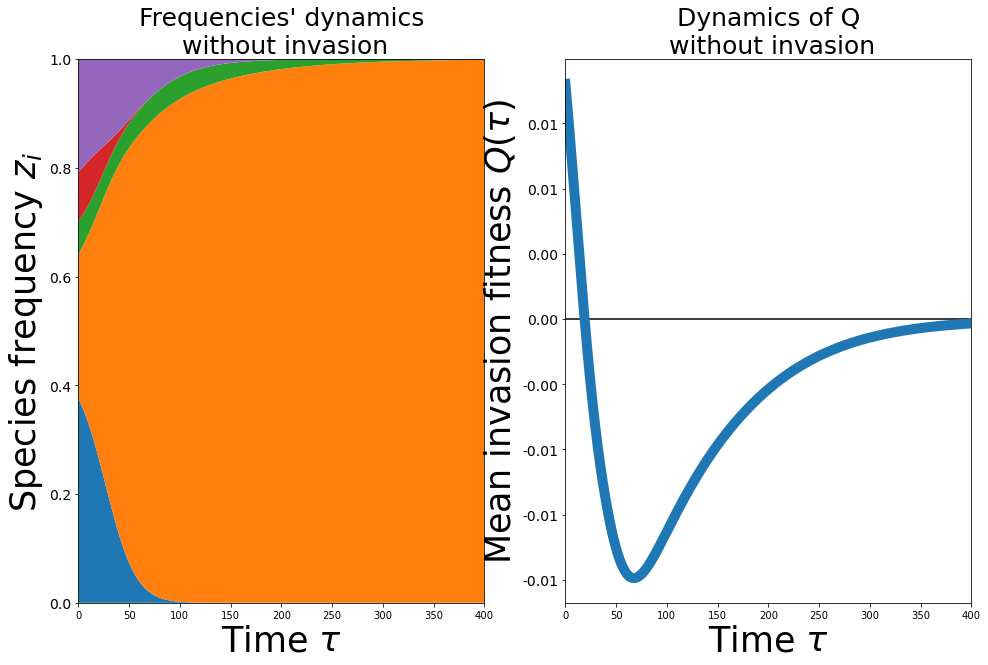

In [15]:
Tmax=400
mu, A,fit1,resultat,nc=simu(n=5,T=Tmax,fit=fit1,z0=z0,mu=0.2)
TT=np.linspace(0,Tmax,1000)
Q=graph_zq(TT,resultat.sol,fit1)


C:\Users\stenm\AppData\Local\Temp/ipykernel_15932/3717727695.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ind_threshold=np.int(np.min(np.arange(0,len(resultat.t),1)[resultat.t>Tstart].tolist()+[T]))
C:\Users\stenm\AppData\Local\Temp/ipykernel_15932/2492545223.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels([f'{round(u,1)}' for u in ax1.get_yticks()],fontsize=14)
C:\Users\stenm\AppData\Local\Temp/ipykernel_15932/2492545223.py:62: UserWarning: FixedFormatter should only be used togethe

The invader fails to invade.


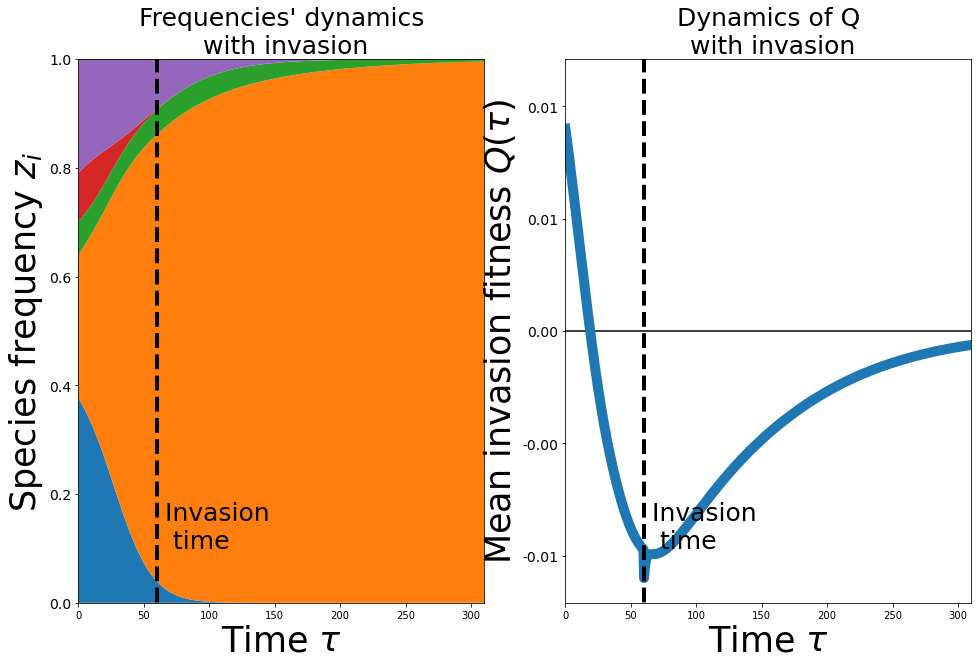

In [21]:
Tstart=150
dico,diconew=invasion(Tstart,TT,resultat.sol,mu=0.2,fit=fit1,Tafter=Tmax-Tstart);
if dico['succes'] : 
    u0='The invader start to growth '
    if dico.pop('long_succes') : u1='and it remains in the system.'
    else : u1='but it does not persist.'
    print(u0+u1)
else : print('The invader fails to invade.')
TT_bilan,Z_bilan=invasion_graph(TT,resultat.sol,**dico);

C:\Users\stenm\AppData\Local\Temp/ipykernel_15932/3717727695.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ind_threshold=np.int(np.min(np.arange(0,len(resultat.t),1)[resultat.t>Tstart].tolist()+[T]))
C:\Users\stenm\AppData\Local\Temp/ipykernel_15932/2492545223.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels([f'{round(u,1)}' for u in ax1.get_yticks()],fontsize=14)
C:\Users\stenm\AppData\Local\Temp/ipykernel_15932/2492545223.py:62: UserWarning: FixedFormatter should only be used togethe

The invader start to growth and it remains in the system.


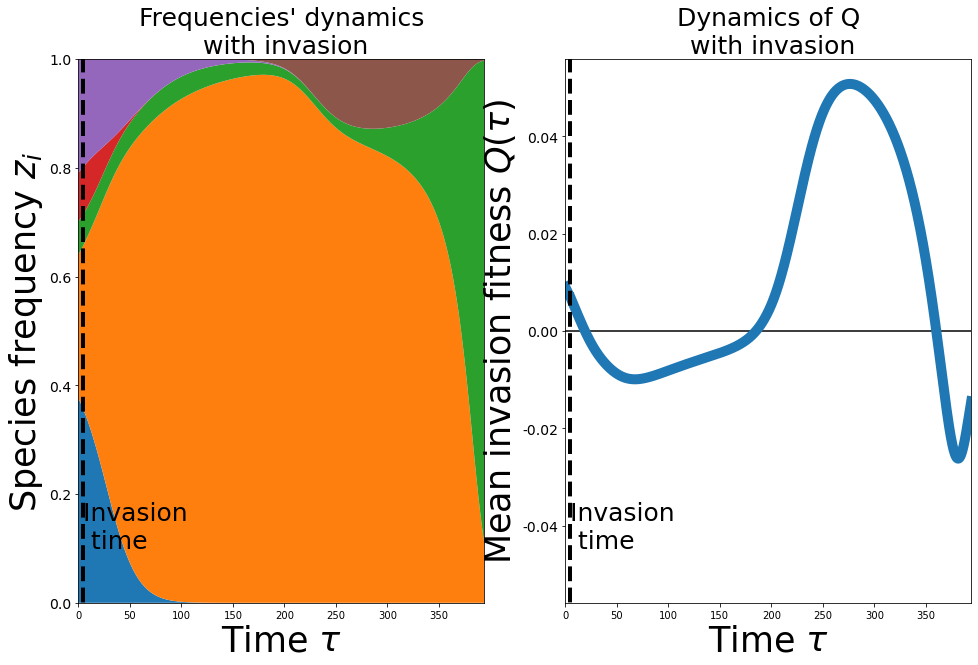

In [20]:
Tstart=10
dico,diconew=invasion(Tstart,TT,resultat.sol,mu=0.2,fit=fit1,Tafter=Tmax-Tstart)
if dico['succes'] : 
    u0='The invader start to growth '
    if dico.pop('long_succes') : u1='and it remains in the system.'
    else : u1='but it does not persist.'
    print(u0+u1)
else : print('The invader fails to invade.')
TT_bilan,Z_bilan=invasion_graph(TT,resultat.sol,**dico)

C:\Users\stenm\AppData\Local\Temp/ipykernel_15932/3717727695.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ind_threshold=np.int(np.min(np.arange(0,len(resultat.t),1)[resultat.t>Tstart].tolist()+[T]))
C:\Users\stenm\AppData\Local\Temp/ipykernel_15932/2492545223.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels([f'{round(u,1)}' for u in ax1.get_yticks()],fontsize=14)
C:\Users\stenm\AppData\Local\Temp/ipykernel_15932/2492545223.py:62: UserWarning: FixedFormatter should only be used togethe

The invader start to growth and it remains in the system.


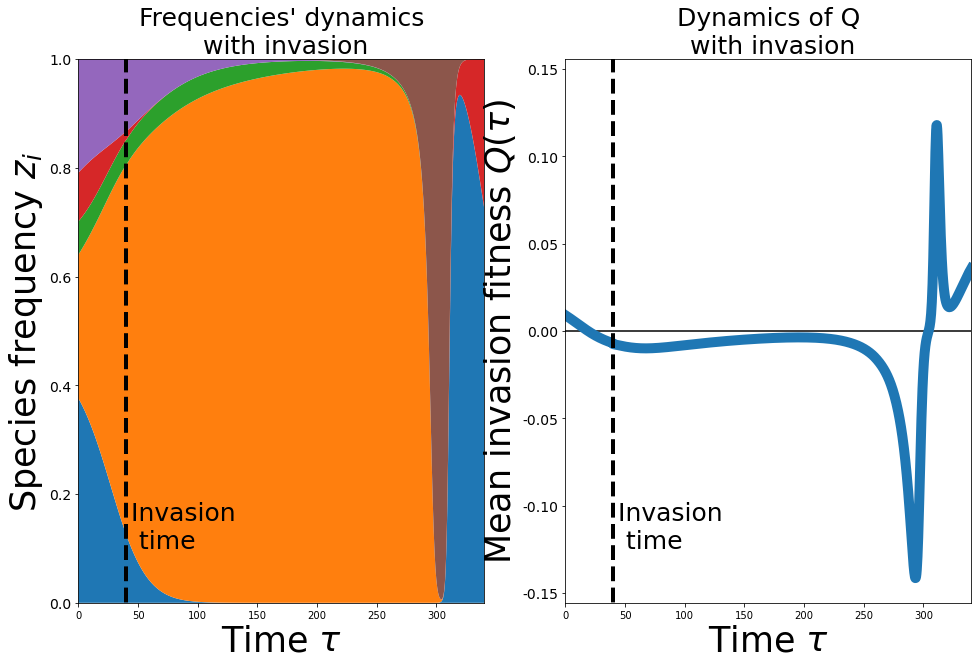

In [22]:
Tstart=100
dico,diconew=invasion(Tstart,TT,resultat.sol,mu=2,fit=fit1,Tafter=Tmax-Tstart)
if dico['succes'] : 
    u0='The invader start to growth '
    if dico.pop('long_succes') : u1='and it remains in the system.'
    else : u1='but it does not persist.'
    print(u0+u1)
else : print('The invader fails to invade.')
TT_bilan,Z_bilan=invasion_graph(TT,resultat.sol,**dico)

## Loop for computing the invasion chances.

In [25]:
number_iter=5
NNumber=[]
Tfin=TT[-1]
NNN1=[]
NNN2=[]
step=2
for _ in range(number_iter):
    #boucle generation de l'invasion
    dico,diconew=invasion(100,TT,resultat.sol,mu=5,fit=fit1,Tafter=10);
    NN1,NN2=[],[]
    times=np.arange(0,len(TT),step)[1:150]
    Number=[]
    for tt in times :
        dico,diconew=invasion(tt,TT,resultat.sol,mu=0.2,fit=fit1,invstrength=diconew['invstrength']
                              ,invresist=diconew['invresist'],Tafter=400)
        A=dico['resultat_inv']['y'][:,-1]
        Number.append(len(A[A>0.01]))
        NN1+=[dico['succes']]
        NN2+=[dico['long_succes']]
    NNN1+=[NN1]
    NNN2+=[NN2]
    NNumber.append(Number)

C:\Users\stenm\AppData\Local\Temp/ipykernel_15932/3717727695.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ind_threshold=np.int(np.min(np.arange(0,len(resultat.t),1)[resultat.t>Tstart].tolist()+[T]))


KeyboardInterrupt: 

In [125]:
TTshow=np.linspace(0,Tmax,len(times))[0:]
len(TTshow)

499

[]

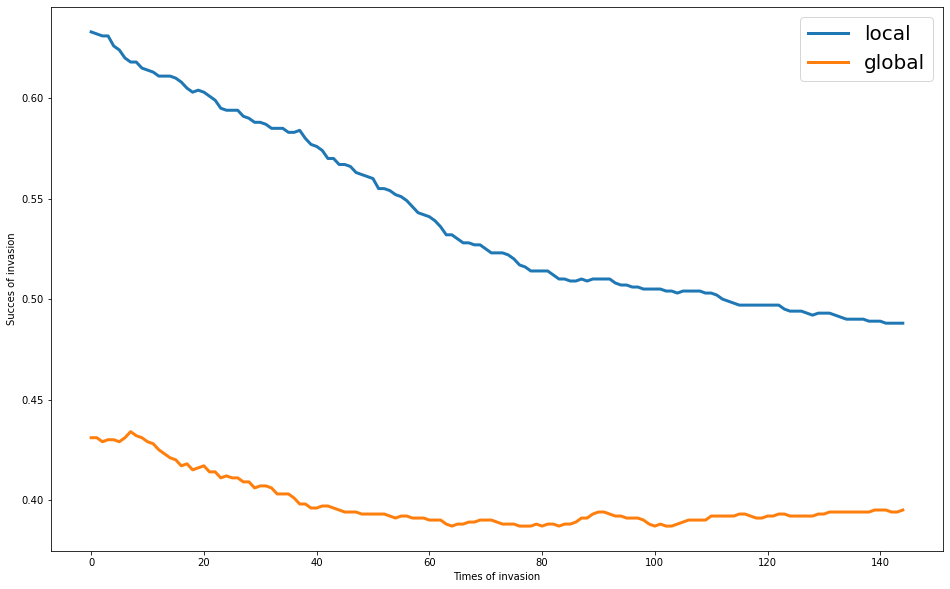

In [351]:
nit=145
A1=np.array(NNN1)[:,0:nit]
A2=np.array(NNN2)[:,0:nit]
plt.plot(np.mean(A1,axis=0),label='local',lw=3)
plt.plot(np.mean(A2,axis=0),label='global',lw=3)
plt.xlabel('Times of invasion')
plt.ylabel('Succes of invasion')
plt.legend(fontsize=20)
plt.plot()

## Finals examples

In [1081]:
fit1=np.array([[ 0.        , -0.02320102, -0.10164639,  0.03640869, -0.00602755],
       [-0.08980463,  0.        ,  0.01830441, -0.11910788, -0.02966253],
       [ 0.07062046, -0.1772426 ,  0.        , -0.12361797,  0.06937789],
       [-0.03367723,  0.04011443,  0.00999484,  0.        , -0.06110504],
       [-0.10651079, -0.19234041,  0.03529692,  0.03750281,  0.        ]])
z0=np.array([0.08094056, 0.12135045, 0.22222566, 0.12022646, 0.45525687])
diconew={'invstrength': np.array([[ 0.87569013, -0.30087286,  0.23783511,  0.86850809, -0.13419327]]),
 'invresist': np.array([[-0.05065334],
        [-0.21917276],
        [ 0.55020449],
        [-0.37995763],
        [-0.98467505],
        [ 0.        ]])}

In [941]:
number_iter=200
NNumber=[]
SShanon=[]
Tfin=TT[-1]
NNN1=[]
NNN2=[]
step=2
for _ in range(number_iter):
    #boucle generation de l'invasion
    dico,diconew=invasion(100,TT,resultat.sol,mu=5,fit=fit1,Tafter=10);
    NN1,NN2=[],[]
    times=np.arange(0,np.int(0.5*len(TT)),step)#[1:150]
    Number=[]
    Shanon=[]
    for tt in times :
        dico,diconew=invasion(tt,TT,resultat.sol,mu=0.2,fit=fit1,invstrength=diconew['invstrength']
                              ,invresist=diconew['invresist'],Tafter=400) 
        A=np.max(dico['resultat_inv']['sol'](dico['TT_inv'])[:,np.int(0.8*len(dico['TT_inv'])):],axis=1)
        Number.append(len(A[A>0.01]))
        Shanon.append(vshanon(A))
        NN1+=[dico['succes']]
        NN2+=[dico['long_succes']]
    NNN1+=[NN1]
    NNN2+=[NN2]
    NNumber.append(Number)
    SShanon.append(Shanon)

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
D:\Anaconda\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


The invader start to growth and it remains in the system.


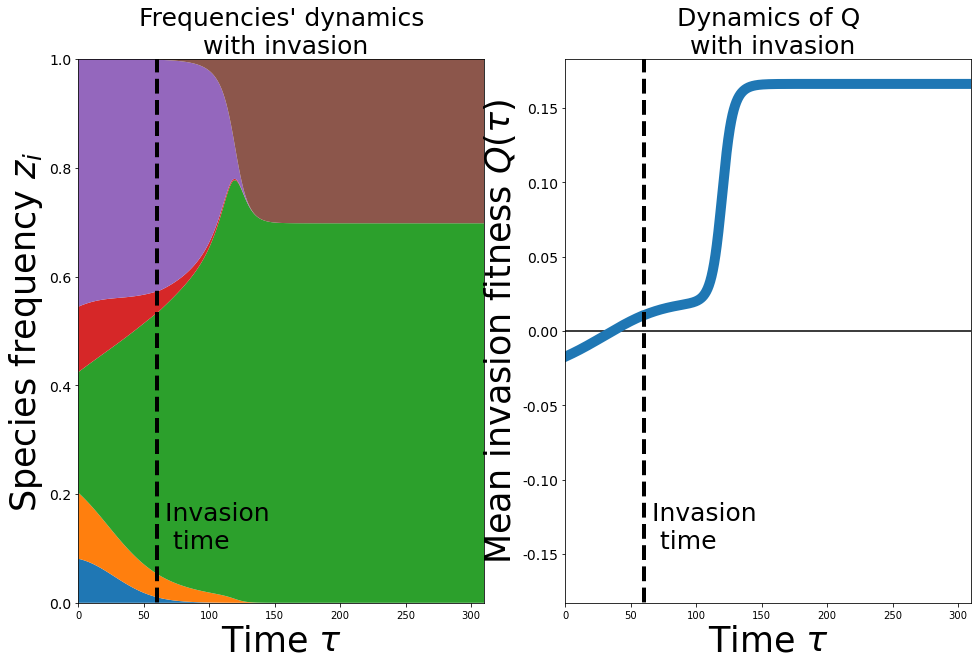

In [940]:
Tstart=150
dico,diconew=invasion(Tstart,TT,resultat.sol,mu=2,fit=fit1,Tafter=Tmax-Tstart,invstrength=diconew['invstrength']
                              ,invresist=diconew['invresist'])
if dico['succes'] : 
    u0='The invader start to growth '
    if dico.pop('long_succes') : u1='and it remains in the system.'
    else : u1='but it does not persist.'
    print(u0+u1)
else : print('The invader fails to invade.')
TT_bilan,Z_bilan=invasion_graph(TT,resultat.sol,**dico)

In [434]:
TT_inv=TT[times]
len(TT_inv)
len(np.mean(A1,axis=0))

145

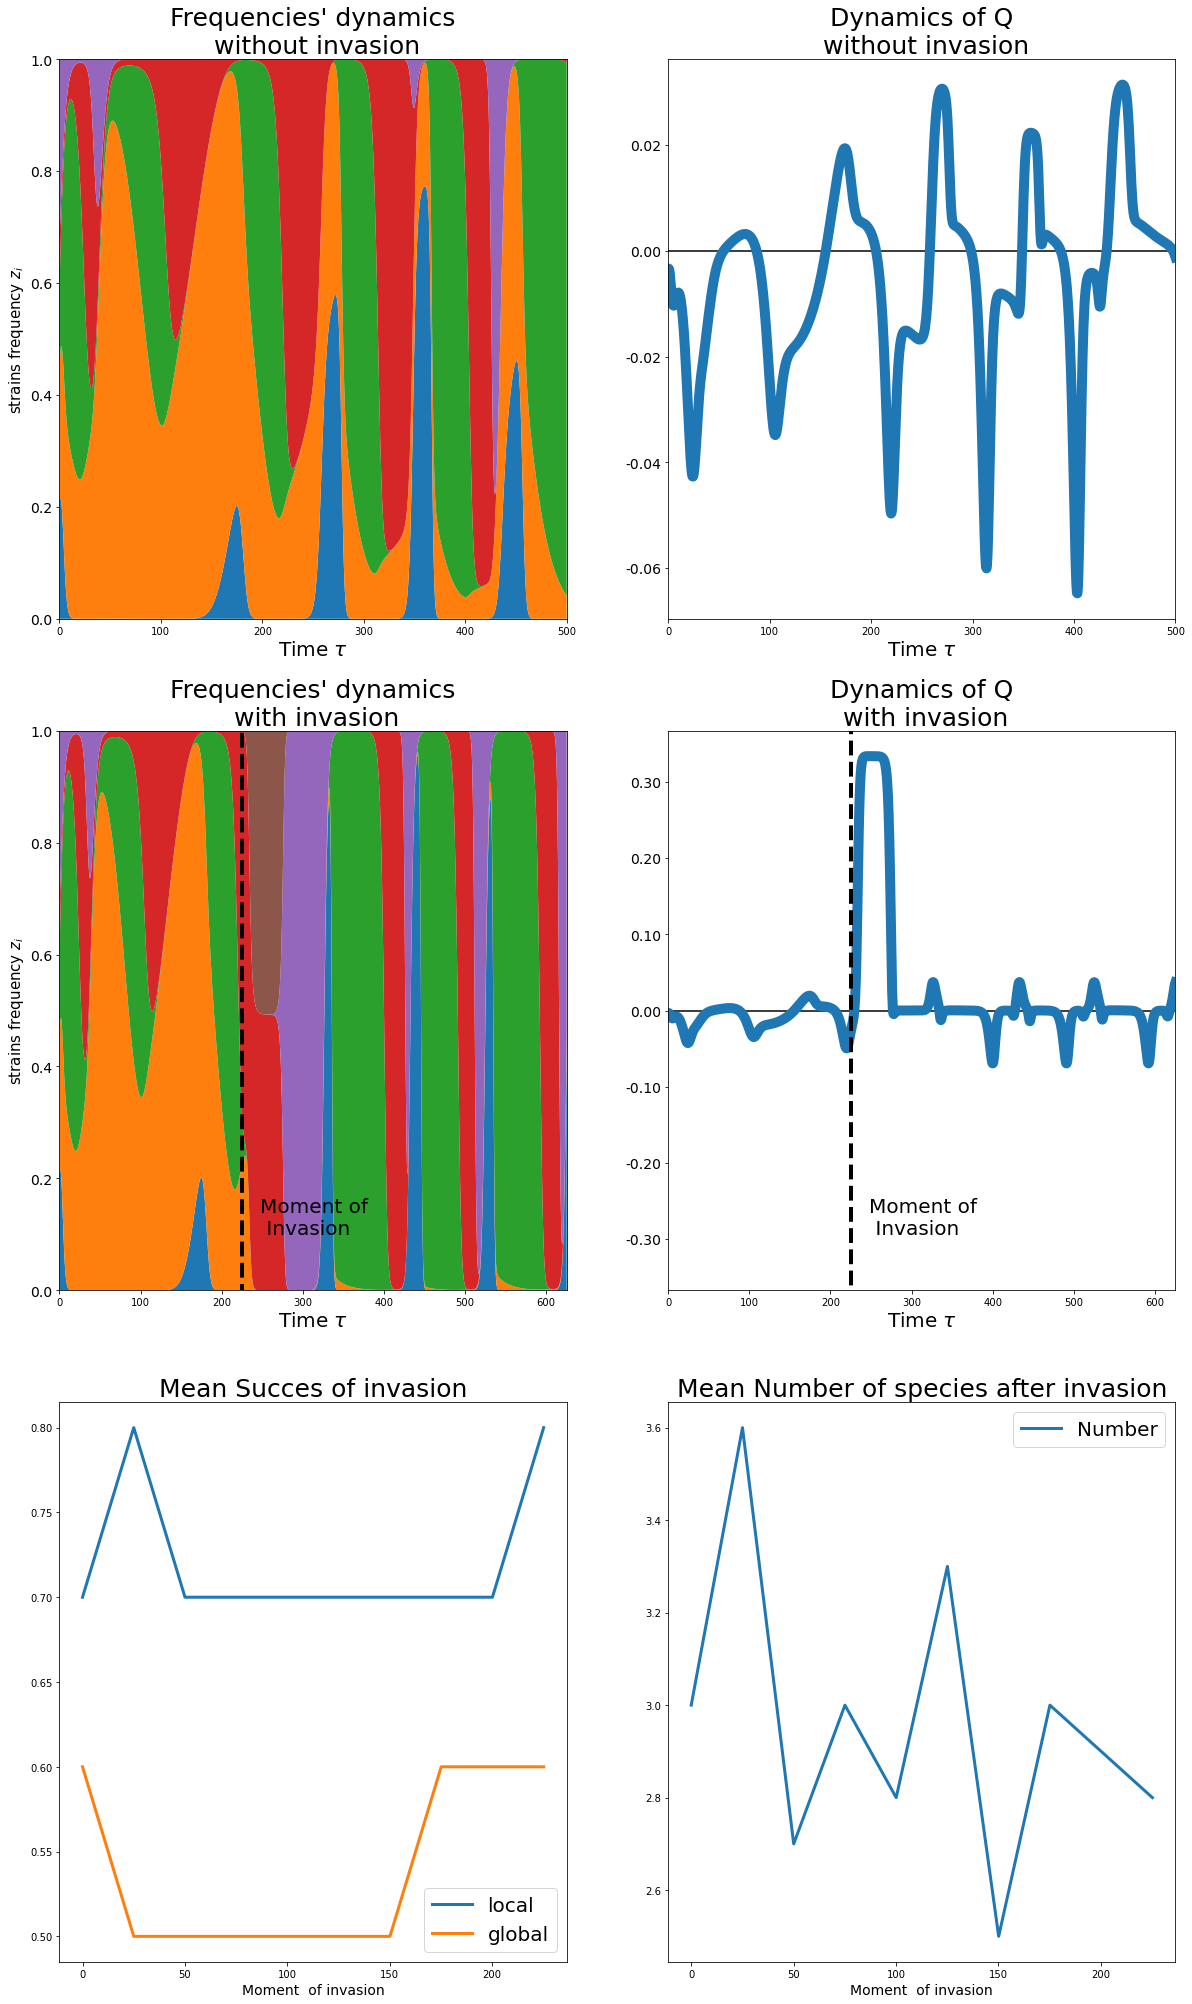

In [761]:
fig,AAX=plt.subplots(nrows=3,ncols=2,figsize=(20,35))
##original examples
Q=graph_zq(TT,resultat.sol,fit1,AX=AAX[0])
##invasion
TT_bilan,Z_bilan=invasion_graph(TT,resultat.sol,AX=AAX[1],**dico)
##mean figures
nit=149
A1=np.array(NNN1)[:,0:nit]
A2=np.array(NNN2)[:,0:nit]
AAX[2][0].plot(TT_inv,np.mean(A1,axis=0),label='local',lw=3)
AAX[2][0].plot(TT_inv,np.mean(A2,axis=0),label='global',lw=3)
AAX[2][0].set_xlabel('Moment  of invasion',fontsize=14)
AAX[2][0].set_title('Mean Succes of invasion',fontsize=25)
AAX[2][0].legend(fontsize=20)
AAX[2][1].plot(TT_inv,np.mean(NNumber,axis=0),label='Number',lw=3)
#AAX[2][1].plot(TT_inv,[2 for _ in times],label='Original',lw=3)
AAX[2][1].set_xlabel('Moment  of invasion',fontsize=14)
AAX[2][1].set_title('Mean Number of species after invasion',fontsize=25)
AAX[2][1].legend(fontsize=20)


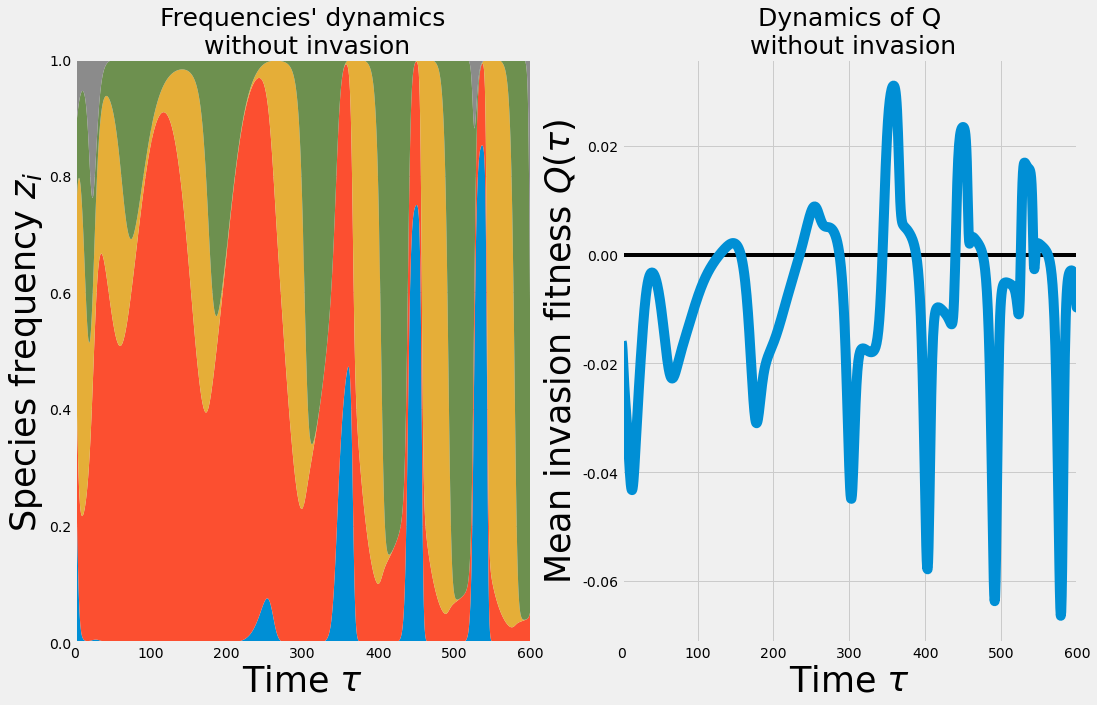

In [1095]:
Tmax=600
mu, A,fit1,resultat,nc=simu(n=5,T=Tmax,fit=fitsave,mu=5)
TT=np.linspace(0,Tmax,1000)
Q=graph_zq(TT,resultat.sol,fit1)

In [1091]:
fitsave=np.array([[ 0.        ,  0.10071657, -1.19349805,  0.54890176,  0.53381377],
       [ 0.02817126,  0.        , -0.06578319,  0.01000835,  0.26436858],
       [ 1.13387386,  0.08894329,  0.        , -0.58273474,  0.10748071],
       [-0.6206168 , -0.08247164,  0.30443823,  0.        , -0.90843825],
       [-0.38263746, -0.29733119, -0.31654563,  0.87632978,  0.        ]])

The invader start to growth and it remains in the system.


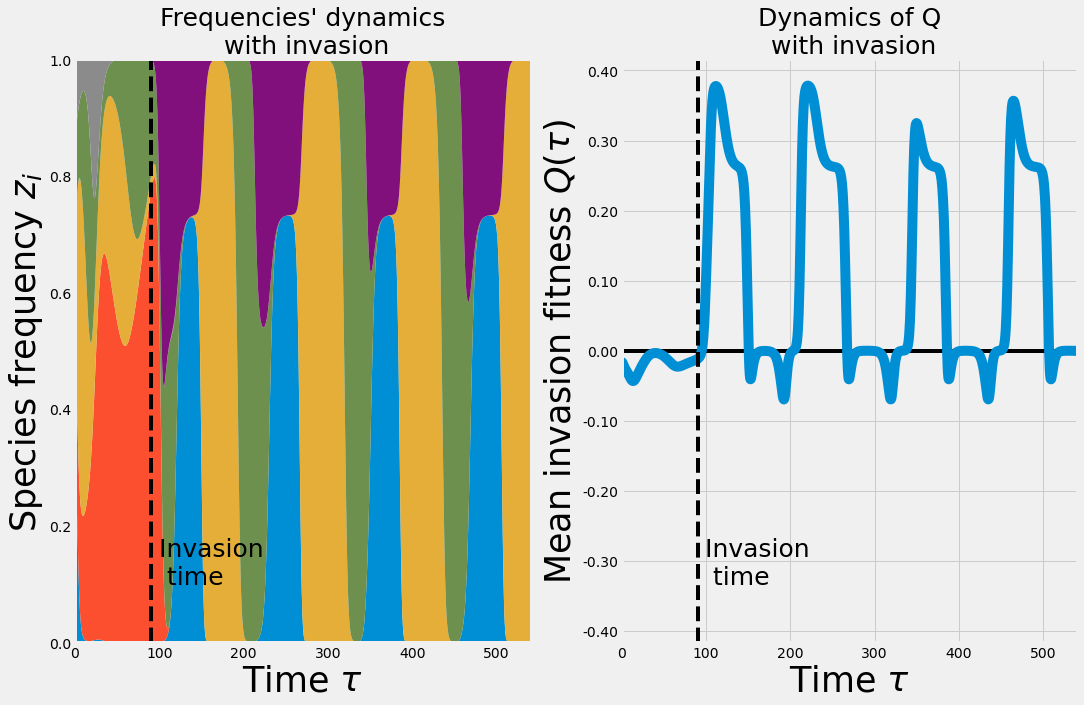

In [1112]:
Tstart=150
dico,diconew=invasion(Tstart,TT,resultat.sol,mu=2,fit=fitsave,Tafter=Tmax-Tstart)
if dico['succes'] : 
    u0='The invader start to growth '
    if dico.pop('long_succes') : u1='and it remains in the system.'
    else : u1='but it does not persist.'
    print(u0+u1)
else : print('The invader fails to invade.')
TT_bilan,Z_bilan=invasion_graph(TT,resultat.sol,**dico)

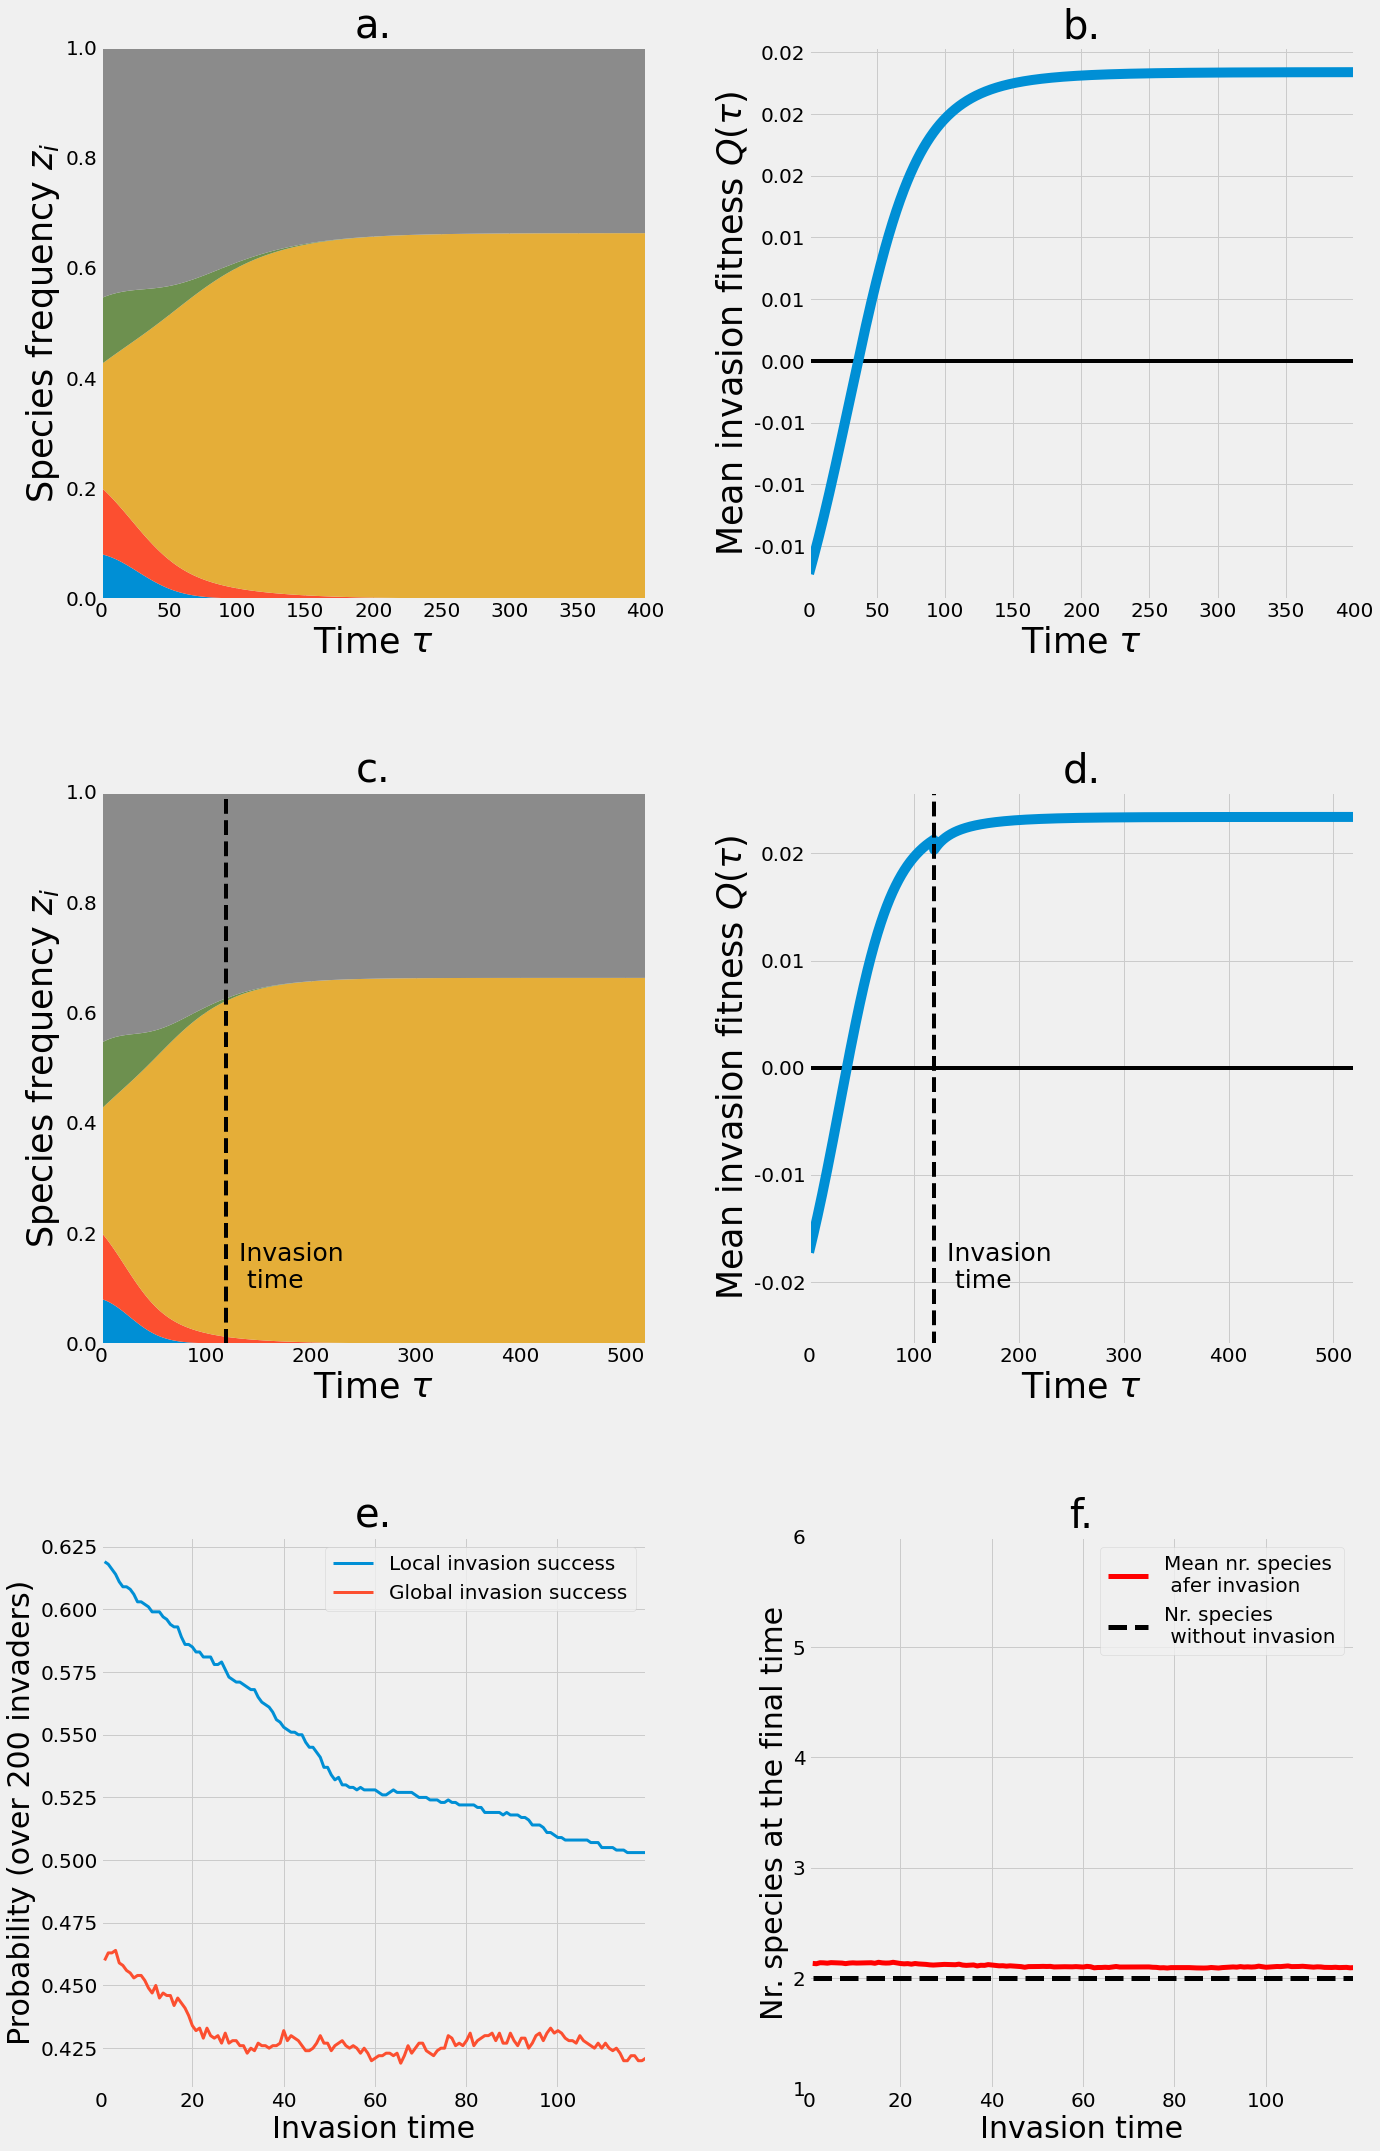

In [1088]:
graph()

In [1113]:
number_iter=1000
NNumber=[]
SShanon=[]
Tfin=TT[-1]
NNN1=[]
NNN2=[]
step=2
for _ in range(number_iter):
    #boucle generation de l'invasion
    dico,diconew=invasion(100,TT,resultat.sol,mu=5,fit=fit1,Tafter=10);
    NN1,NN2=[],[]
    times=np.arange(0,np.int(0.5*len(TT)),step)#[1:150]
    Number=[]
    Shanon=[]
    for tt in times :
        dico,diconew=invasion(tt,TT,resultat.sol,mu=0.2,fit=fit1,invstrength=diconew['invstrength']
                              ,invresist=diconew['invresist'],Tafter=400) 
        A=np.max(dico['resultat_inv']['sol'](dico['TT_inv'])[:,np.int(0.8*len(dico['TT_inv'])):],axis=1)
        Number.append(len(A[A>0.01]))
        Shanon.append(vshanon(A))
        NN1+=[dico['succes']]
        NN2+=[dico['long_succes']]
    NNN1+=[NN1]
    NNN2+=[NN2]
    NNumber.append(Number)
    SShanon.append(Shanon)

D:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
D:\Anaconda\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide


In [1089]:
def graph(nori=2,name=['a.','b.','c.','d.','e.','f.']):
    
    TT_inv=TT[times]
    fig,AAX=plt.subplots(nrows=3,ncols=2,figsize=(20,35))
    ##original examples
    Q=graph_zq(TT,resultat.sol,fit1,AX=AAX[0])
    AAX[0][0].set_title(name[0],fontsize=40)
    AAX[0][1].set_title(name[1],fontsize=40)
    ##invasion
    TT_bilan,Z_bilan=invasion_graph(TT,resultat.sol,AX=AAX[1],**dico)
    AAX[1][0].set_title(name[2],fontsize=40)
    AAX[1][1].set_title(name[3],fontsize=40)
    ##mean figures
    nit=len(times)
    A1=np.array(NNN1)[:,0:nit]
    A2=np.array(NNN2)[:,0:nit]
    AAX[2][0].plot(TT_inv,np.mean(A1,axis=0),label='Local invasion success',lw=3)
    AAX[2][0].plot(TT_inv,np.mean(A2,axis=0),label='Global invasion success',lw=3)
    AAX[2][0].set_xlabel('Invasion time',fontsize=30)
    AAX[2][0].set_title(name[4],fontsize=40)
    AAX[2][0].legend(fontsize=20)
    #AAX[2][1].plot(TT_inv,[nori for _ in times],'--k',label='Original',lw=3)
    #AAX[2][1].plot(TT_inv,np.array(NNumber).T,'dr',alpha=0.1,label='Number',ms=20)
    #AAX[2][1].scatter(TT_inv,np.array(NNumber).T,'dr',alpha=0.1,label='Number',ms=20)
    #AAX[2][1].boxplot(TT_inv,np.array(NNumber).T)
    AAX[2][1].plot(TT_inv,np.mean(np.array(NNumber).T,axis=1),'-r',label='Mean nr. species\n afer invasion',lw=5)
    AAX[2][1].plot(TT_inv,[nori for _ in times],'--k',label='Nr. species \n without invasion',lw=5)
    AAX[2][1].set_xlabel('Invasion time',fontsize=30)
    AAX[2][1].set_ylabel('Nr. species at the final time',fontsize=30)
    AAX[2][0].set_ylabel('Probability (over 200 invaders)',fontsize=30)
    AAX[2][1].set_title(name[5],fontsize=40)
    AAX[2][1].legend(fontsize=20)
    AAX[2][1].set_ylim((nori-1,nori+1))
    AAX[2][1].set_xlim((0,TT_inv[-1]))
    AAX[2][0].set_xlim((0,TT_inv[-1]))
    for AX in AAX:
        for ax in AX:
            ax.tick_params(axis='x', labelsize=20)
            ax.tick_params(axis='y', labelsize=20)
    plt.subplots_adjust(wspace=0.3,hspace=0.35 )

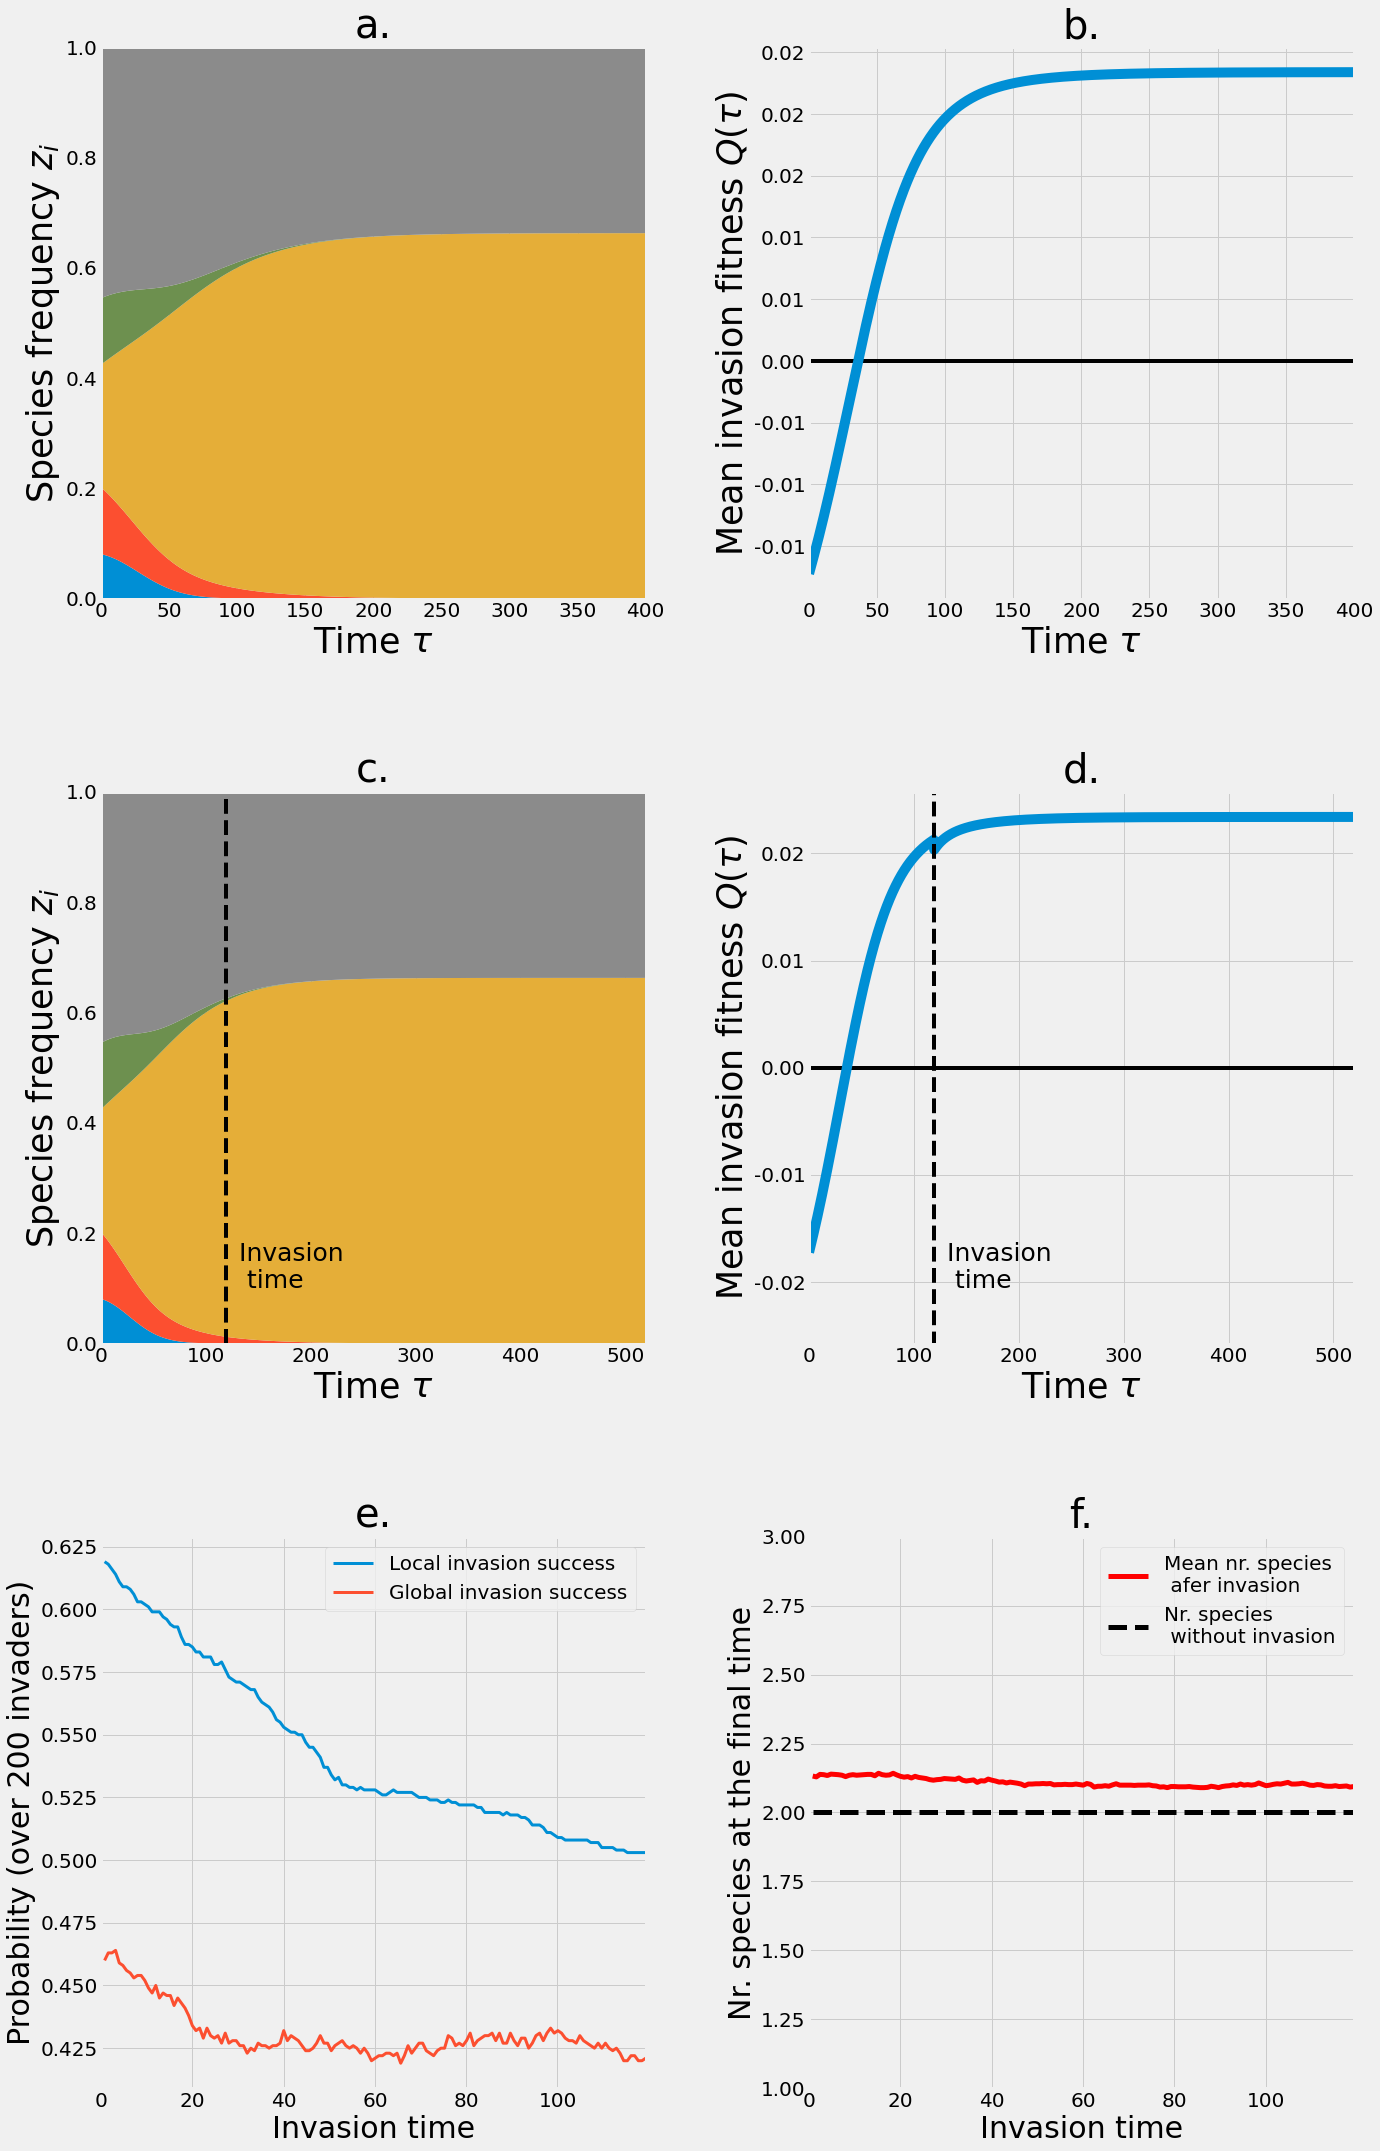

In [1090]:
graph()

## Examples

In [11]:
fit0=np.array(
    [[ 0.  ,       -0.00164727, 0.21365872,  0.05236705 , 0.15022009],
     [-0.11388638,  0.    ,      0.06430139 , 0.20233032 , 0.17166176],
     [-0.14697685 , 0.01381513 , 0.          ,0.04492413 , 0.12679379],
     [-0.01121255 , 0.00559903 , 0.21812023 , 0.         , 0.19002136],
     [-0.05904439 , 0.12634339 , 0.07831928,  0.10060035 , 0.        ]])

In [38]:
A0=np.array([[-0.03820204,  0.10827497,  0.05977761, -0.11682861, -0.13078331],
       [ 0.13269453, -0.00997668,  0.04072531, -0.11325818,  0.07185538],
       [-0.01870592,  0.05778324, -0.13148627,  0.01496649,  0.01582889],
       [-0.12070303, -0.07640338, -0.0180525 ,  0.08220433, -0.01515157],
       [ 0.00903088, -0.03374282,  0.00504482, -0.01551257,  0.04667688]])

In [215]:
A1=np.array([[ 0.01242596, -0.08409443,  0.14254315,  0.13365438,  0.13446742],
       [-0.08737766,  0.04827938, -0.02812062, -0.13348461,  0.04385661],
       [ 0.01508523, -0.00616994,  0.06571539, -0.01152304, -0.0604985 ],
       [-0.00879053,  
        0.06107819, -0.10581359,  0.0153213 ,  0.14625011],
       [-0.08589802, -0.05070623,  0.05614015, -0.06802034,  0.02059873]])